 ### 1. Installazione e importazione delle librerie necessarie
 

In [ ]:
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2 
!bzip2 -dk mmod_human_face_detector.dat.bz2 

In [ ]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import ZeroPadding2D,Conv2D,MaxPooling2D
from keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization,Input,AveragePooling2D
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.imagenet_utils import preprocess_input
import keras.backend as K

import dlib
import pickle

import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from sklearn.metrics import classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

from keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/My Drive/DSIM Project/processing2D/'
folds_path = PATH + 'images/'
dump_path = PATH + 'dump/'
faces_path = PATH + 'faces/'

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Creazione delle immagini ritagliate

- **create_cropped_face**: questa funzione ritaglia solamente la faccia partendo dalle immagini originali. In particolare, per fare questo lavoro viene usato un *face detector*, che individua automaticamente la faccia di una persona; successivamente essa viene ritagliata e salvata in un'apposita cartella.
Purtroppo, non sempre il *face detector* riesce ad individuare correttamente la faccia di una persona (probabilmente per la scarsa qualità di alcune immagini). Per rimediare a tale problema, si è deciso di fare un *cropping* "manuale" delle immagini, ovvero si parte dal punto centrale dell'immagine e ci si muove di 90 in ogni direzione, ottenendo un'immagine simile a quella ritagliata dal *face detector*. Anche queste immagini sono poi state salvate in un'apposita cartella.
Tutte le immagini hanno dimensione *224x224*.

In [ ]:
def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()

def create_cropped_faces():

  dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

  for fold in os.listdir(folds_path):
    if not os.path.exists(faces_path+fold):
        os.mkdir(faces_path+fold)
    perc_ = 1
    for image in os.listdir(os.path.join(folds_path,fold)):
      try:
        #carico l'immagine 
        img = cv.imread(os.path.join(folds_path,fold,image))
        rects=dnnFaceDetector(img,2)
        left,top,right,bottom=0,0,0,0
        # For each face 'rect' provides face location in image as pixel loaction
        for (i,rect) in enumerate(rects):
          left=rect.rect.left() #x1
          top=rect.rect.top() #y1
          right=rect.rect.right() #x2
          bottom=rect.rect.bottom() #y2
          width=right-left
          height=bottom-top

          # Crop image 
        face = img[top:top+height,left:left+width]
        face = cv.resize(face, (224,224), interpolation = cv.INTER_AREA)
        img = cv.cvtColor(face, cv.COLOR_BGR2RGB)
        cv.imwrite(faces_path+fold+'/'+image, img)
        plt.imshow(img)
        plt.show()

        #barra di caricamento %
        printProgressBar(perc_,
                        len(os.listdir(os.path.join(folds_path,fold))),
                        str(fold))
        perc_+=1
      
      except:
        print("\n An exception occurred: ", image)
        img = cv.imread(os.path.join(folds_path,fold,image))
        w = round(img.shape[1]/2)
        h = round(img.shape[0]/2)
        face = img[h-90:h+90, w-90:w+90]
        img = cv.resize(img, (224,224), interpolation = cv.INTER_AREA)
        img = cv.cvtColor(face, cv.COLOR_BGR2RGB)
        cv.imwrite(faces_path+fold+'/'+image, img)
        plt.imshow(img)
        plt.show()

        printProgressBar(perc_,
                        len(os.listdir(os.path.join(folds_path,fold))),
                        str(fold))
        perc_+=1
    print('----> done!' )

In [ ]:
create_cropped_faces()

### 3. Caricamento delle immagini con le relative labels

- **data_loader**: in questa funzione vengono prese le immagini precedentemente ritagliate (*create_cropped_faces()*) e pre-processate per il successivo training del modello. Inoltre, vengono create le *labels* associate alle immagini: in particolare, se la variabile *objective* è *\"people"*, allora si avranno 3 labels (Federico, Anastasia e Davide) da *2* classi (0,1); se *objective* è *\"mask"* allora si avranno 2 classi (mask Yes, mask No).

In [ ]:
def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()

def data_loader(objective,path,height=224,width=224,test_size=0.25,random_state=42):
  
  if not os.path.isfile(os.path.join(dump_path,"data_"+objective+".txt")):

    print('Data creation...')
    X=[]
    y=[]

    for fold in os.listdir(path):
      person=fold.split("_")[0]
      mask=fold.split("_")[1]

      perc_=1

      for image in os.listdir(os.path.join(path,fold)):   
        printProgressBar(perc_,
                        len(os.listdir(os.path.join(path,fold))),
                        str(fold))
        perc_+=1

        img=load_img(os.path.join(path,fold,image),target_size=(height,width)) 
        img=img_to_array(img)
        img=np.expand_dims(img,axis=0)
        img=preprocess_input(img)
        X.append(img.tolist())

        if objective=="people":
          y.append(person)

          y_ana = []
          y_fede = []
          y_dav = []

          for name in y:
            if name=="federico":
              y_fede.append(1)
              y_ana.append(0)
              y_dav.append(0)

            elif name=="anastasia":
              y_ana.append(1)
              y_fede.append(0)
              y_dav.append(0)

            elif name=="davide":
              y_dav.append(1)
              y_ana.append(0)
              y_fede.append(0)

          Y = [y_fede, y_ana, y_dav]
        
        elif objective=="mask":
          y.append(mask)

          Y=[]
          for mask in y:
            if mask=="maskno":
              Y.append(0)
            elif mask=="maskyes":
              Y.append(1)

    X=np.array(X)
    Y=np.array(Y)

    if objective=="people":
      Y=to_categorical(Y,2)
      X=X.reshape(-1,height,width,3)
      X_train, X_test, y_train_fede, y_test_fede = train_test_split(X, Y[0], test_size=0.2, random_state=42)
      X_train, X_test, y_train_ana, y_test_ana = train_test_split(X, Y[1], test_size=0.2, random_state=42)
      X_train, X_test, y_train_dav, y_test_dav = train_test_split(X, Y[2], test_size=0.2, random_state=42)

      Y_train = [y_train_fede, y_train_ana, y_train_dav]
      Y_test = [y_test_fede, y_test_ana, y_test_dav]
    
    elif objective=="mask":
      Y=to_categorical(Y,2)
      X=X.reshape(-1,height,width,3)
      X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=test_size,random_state=random_state,shuffle=True)

      Y_train = [Y_train]
      Y_test = [Y_test]

    with open(dump_path + "data_"+objective+".txt", "wb") as f:
        pickle.dump([X_train, X_test, Y_train, Y_test], f)
    print("Done!")
  
  else:
    print("Restoring dump...")
    with open(dump_path + "data_"+objective+".txt", "rb") as f:
      X_train, X_test, Y_train, Y_test = pickle.load(f)
    print("Done!")

  return X_train, X_test, Y_train, Y_test  

### 4. Creazione del modello
#### 4.1 Caricamento di una implementazione della VGGface *(https://gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9)* coi relativi pesi.

In [ ]:
def vgg_face_architecture(height,width,channels, input_layer):
  
  #img = Input(shape=(height,width,channels))
  img = input_layer

  pad1_1 = ZeroPadding2D(padding=(1, 1))(img)
  conv1_1 = Conv2D(64, (3, 3), activation='relu', name='conv1_1')(pad1_1)
  pad1_2 = ZeroPadding2D(padding=(1, 1))(conv1_1)
  conv1_2 = Conv2D(64, (3, 3), activation='relu', name='conv1_2')(pad1_2)
  pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

  pad2_1 = ZeroPadding2D((1, 1))(pool1)
  conv2_1 = Conv2D(128, (3, 3), activation='relu', name='conv2_1')(pad2_1)
  pad2_2 = ZeroPadding2D((1, 1))(conv2_1)
  conv2_2 = Conv2D(128, (3, 3), activation='relu', name='conv2_2')(pad2_2)
  pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

  pad3_1 = ZeroPadding2D((1, 1))(pool2)
  conv3_1 = Conv2D(256, (3, 3), activation='relu', name='conv3_1')(pad3_1)
  pad3_2 = ZeroPadding2D((1, 1))(conv3_1)
  conv3_2 = Conv2D(256, (3, 3), activation='relu', name='conv3_2')(pad3_2)
  pad3_3 = ZeroPadding2D((1, 1))(conv3_2)
  conv3_3 = Conv2D(256, (3, 3), activation='relu', name='conv3_3')(pad3_3)
  pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

  pad4_1 = ZeroPadding2D((1, 1))(pool3)
  conv4_1 = Conv2D(512, (3, 3), activation='relu', name='conv4_1')(pad4_1)
  pad4_2 = ZeroPadding2D((1, 1))(conv4_1)
  conv4_2 = Conv2D(512, (3, 3), activation='relu', name='conv4_2')(pad4_2)
  pad4_3 = ZeroPadding2D((1, 1))(conv4_2)
  conv4_3 = Conv2D(512, (3, 3), activation='relu', name='conv4_3')(pad4_3)
  pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

  pad5_1 = ZeroPadding2D((1, 1))(pool4)
  conv5_1 = Conv2D(512, (3, 3), activation='relu', name='conv5_1')(pad5_1)
  pad5_2 = ZeroPadding2D((1, 1))(conv5_1)
  conv5_2 = Conv2D(512, (3, 3), activation='relu', name='conv5_2')(pad5_2)
  pad5_3 = ZeroPadding2D((1, 1))(conv5_2)
  conv5_3 = Conv2D(512, (3, 3), activation='relu', name='conv5_3')(pad5_3)
  pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

  fc6 = Conv2D(4096, (7, 7), activation='relu', name='fc6')(pool5)
  fc6_drop = Dropout(0.5)(fc6)
  fc7 = Conv2D(4096, (1,1), activation='relu', name='fc7')(fc6_drop)
  fc7_drop = Dropout(0.5)(fc7)
  fc8 = Conv2D(2622, (1,1), name='fc8')(fc7_drop)

  vgg_face = Model(input=img, output=fc8)
  vgg_face.load_weights('/content/drive/My Drive/DSIM Project/processing2D/vgg_face_weights.h5')

  return vgg_face

#### 4.2 Fine-tuning della rete pre-trained

- Una volta importato il modello VGGface, sono stati aggiunti 5 blocchi composti da 2 hidden layers di tipo fully-connected e 1 layer di dropout (*dropout_rate = 0.3*), con una struttura ad imbuto: *1024* neuroni per il primo blocco, *512* neuroni per il secondo blocco, *256* neuroni per il terzo blocco, *128* neuroni per il quarto blocco e *64* neuroni per il primo blocco. Per tutti i layers è stata utilizzata la funzione di attivazione *relu*.
Infine, è stato aggiunto un layer di output con 2 neuroni e funzione di attivazione *softmax* per l'objective *mask*; mentre, per l'objective *people*, sono stati aggiunti 3 layers di output, ognuno con 2 neuroni e funzione di attivazione *softmax*.

- Come funzione di *loss* è stata utilizzata la *binary cross-entropy* e come funzione di ottimizzazione *Adam*, con learning rate fisso a *0.001*.





In [ ]:
def fine_tuning(objective):

  height,width,channels = (224, 224, 3)

  input_layer = Input((height,width,channels))

  vgg_face = vgg_face_architecture(height,width,channels, input_layer)

  for layer in vgg_face.layers:
    layer.trainable=False

  base_model = vgg_face.output

  x = Flatten()(base_model)

  x = Dense(1024,activation="relu")(x)
  x = Dense(1024,activation="relu")(x)
  x = Dropout(0.3)(x)

  x = Dense(512, activation="relu")(x)
  x = Dense(512,activation="relu")(x)
  x = Dropout(0.3)(x)

  x = Dense(256, activation="relu")(x)
  x = Dense(256,activation="relu")(x)
  x = Dropout(0.3)(x)

  x = Dense(128, activation="relu")(x)
  x = Dense(128,activation="relu")(x)
  x = Dropout(0.3)(x)

  x = Dense(64,activation="relu")(x)
  x = Dense(64,activation="relu")(x)
  x = Dropout(0.3)(x)

  if objective=='people':
    out_fede = Dense(2,activation="softmax", name='federico')(x)
    out_ana = Dense(2,activation="softmax", name='anastasia')(x)
    out_dav = Dense(2,activation="softmax", name='davide')(x)

    model = Model(input_layer,[out_fede, out_ana, out_dav])

    losses = {"federico": "binary_crossentropy",
              "anastasia": "binary_crossentropy",
              "davide": "binary_crossentropy"}

    model.compile(loss = losses,
                optimizer = Adam(lr=0.001),
                metrics = ["accuracy"])
  else:

    output_layer = Dense(2,activation="softmax")(x)
    model = Model(input_layer,output_layer)
    model.compile(loss = "binary_crossentropy",
                  optimizer = Adam(lr=0.001),
                  metrics = ["accuracy"])

  return model

#### 4.3 Data augmentation
Le immagini sono state modificate nel seguente modo, per i dati di training:
- *rotation_range=15*
- *zoom_range=0.3*
- *brightness_range=[0.2,1.0]*
- *height_shift_range=0.3*
- *width_shift_range=0.3*
- *fill_mode=nearest*

Sia per i dati di training che di validation, è stata effettutta la normalizzazione *rescale=1./255*

In [ ]:
def multi_data_generator(generator, X, y_list, batch_size):
    y_item_0 = y_list[0]
    y_indices = np.arange(y_item_0.shape[0])
    orig_flow = generator.flow(X, y=y_indices, batch_size=batch_size)

    while True:
        (X, y_next_i) = next(orig_flow)
        y_next = [y_item[y_next_i] for y_item in y_list]
        yield X, y_next


def get_generators(X_train,Y_train,X_test,Y_test):
  
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=15, 
                                     zoom_range = 0.3,
                                     brightness_range=[0.2,1.0],
                                     height_shift_range=0.3,
                                     width_shift_range = 0.3,
                                     fill_mode="nearest")
                          
  train_data_generator = multi_data_generator(train_datagen, X_train, 
                                      Y_train, batch_size=32)
  
  test_datagen=ImageDataGenerator(rescale=1./255)
  test_data_generator=multi_data_generator(test_datagen,X_test,Y_test,batch_size=32)

  return train_data_generator, test_data_generator

### 5. Training del modello e risultati
Per il training del modello sono stati tulizzati i seguenti parametri:
- *numero di epoche: 50*
- *steps_per_epoch= len(X)/32*

I modelli sono infine stati salvati per la creazione della demo.

In [ ]:
def training_model(objective):

  X_train, X_test, Y_train, Y_test = data_loader(objective,
                                                 faces_path,
                                                 224,224,
                                                 test_size=0.3)
  
  model=fine_tuning(objective)

  train_generator, test_generator = get_generators(X_train, Y_train,
                                                   X_test, Y_test)
  
  history = model.fit_generator(train_generator, 
                                steps_per_epoch= len(X_train)/32, 
                                epochs=50, 
                                verbose=2, 
                                shuffle=True,
                                validation_data=test_generator,
                                validation_steps=len(X_test)/32)
  
  if objective == 'people':
    names = ['Federico', 'Anastasia', 'Davide']
    pos = 0
    y_pred = model.predict(X_test)

    for y in Y_test:
      print("\n -", names[pos])
      y_pred_ = np.argmax(y_pred[pos], axis = 1)
      y_test = np.argmax(y, axis = 1)
      print(classification_report(y_test, y_pred_, digits = 2))
      pos+=1

  else:
    target_names = ['Mask No', 'Mask Yes']
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1)
    y_test = np.argmax(Y_test[0], axis = 1)
    print("\n Classification report of", objective, 
          "\n", classification_report(y_test, y_pred, digits = 2, target_names=target_names))

  model.save("/content/drive/My Drive/DSIM Project/processing2D/models_saved/vggface_{}".format(objective))
  
  return history, model

In [ ]:
def plot_history(history, objective):

  if objective=='people':
    fig = plt.figure(figsize=(20,10))
    #----------------- ANASTASIA---------------------------
    fig.add_subplot(2,3,1)
    plt.plot(history.history['anastasia_accuracy'])
    plt.plot(history.history['val_anastasia_accuracy'])
    plt.title('model accuracy - ANASTASIA')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    fig.add_subplot(2,3,4)
    plt.plot(history.history['anastasia_loss'])
    plt.plot(history.history['val_anastasia_loss'])
    plt.title('model loss - ANASTASIA')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    #----------------- FEDERICO---------------------------
    fig.add_subplot(2,3,2)
    plt.plot(history.history['federico_accuracy'])
    plt.plot(history.history['val_federico_accuracy'])
    plt.title('model accuracy - FEDERICO')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    fig.add_subplot(2,3,5)
    plt.plot(history.history['federico_loss'])
    plt.plot(history.history['val_federico_loss'])
    plt.title('model loss - FEDERICO')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    #----------------- DAVIDE---------------------------
    fig.add_subplot(2,3,3)
    plt.plot(history.history['davide_accuracy'])
    plt.plot(history.history['val_davide_accuracy'])
    plt.title('model accuracy - DAVIDE')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    fig.add_subplot(2,3,6)
    plt.plot(history.history['davide_loss'])
    plt.plot(history.history['val_davide_loss'])
    plt.title('model loss - DAVIDE')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

  else:
    fig = plt.figure(figsize=(14,5))
    #------------- VOCAL ASSISTANT----------------------
    fig.add_subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy - MASK')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    fig.add_subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - MASK')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

In [ ]:
history_people, model_people = training_model("people")

Restoring dump...
Done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`


Epoch 1/50
 - 24s - loss: 1.9441 - federico_loss: 0.6113 - anastasia_loss: 0.6847 - davide_loss: 0.6480 - federico_accuracy: 0.6663 - anastasia_accuracy: 0.6694 - davide_accuracy: 0.6632 - val_loss: 1.7020 - val_federico_loss: 0.5021 - val_anastasia_loss: 0.6566 - val_davide_loss: 0.6319 - val_federico_accuracy: 0.6375 - val_anastasia_accuracy: 0.6958 - val_davide_accuracy: 0.6667
Epoch 2/50
 - 12s - loss: 1.4907 - federico_loss: 0.4904 - anastasia_loss: 0.4596 - davide_loss: 0.5407 - federico_accuracy: 0.6788 - anastasia_accuracy: 0.8780 - davide_accuracy: 0.6663 - val_loss: 1.0640 - val_federico_loss: 0.5522 - val_anastasia_loss: 0.1036 - val_davide_loss: 0.4990 - val_federico_accuracy: 0.6375 - val_anastasia_accuracy: 0.9958 - val_davide_accuracy: 0.6667
Epoch 3/50
 - 15s - loss: 1.0893 - federico_loss: 0.4931 - anastasia_loss: 0.0993 - davide_loss: 0.4969 - federico_accuracy: 0.6840 - anastasia_accuracy: 0.9781 - davide_accuracy: 0.6621 - val_loss: 0.8242 - val_federico_loss: 0.444

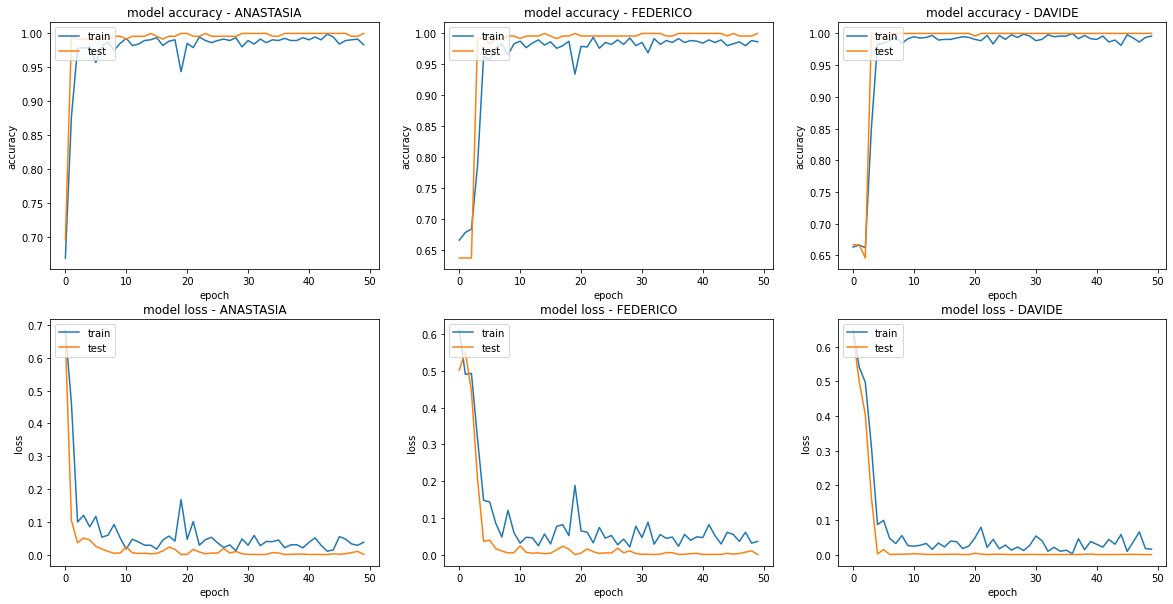

In [ ]:
plot_history(history_people, 'people')

In [ ]:
history_mask, model_mask = training_model("mask")

Restoring dump...
Done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`


Epoch 1/50
 - 21s - loss: 0.6480 - accuracy: 0.6126 - val_loss: 0.7327 - val_accuracy: 0.6861
Epoch 2/50
 - 12s - loss: 0.1765 - accuracy: 0.9380 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 3/50
 - 13s - loss: 0.1894 - accuracy: 0.9583 - val_loss: 7.7900e-05 - val_accuracy: 0.9889
Epoch 4/50
 - 13s - loss: 0.0948 - accuracy: 0.9702 - val_loss: 1.2128 - val_accuracy: 0.8278
Epoch 5/50
 - 13s - loss: 0.0979 - accuracy: 0.9750 - val_loss: 0.0027 - val_accuracy: 0.9889
Epoch 6/50
 - 13s - loss: 0.0887 - accuracy: 0.9785 - val_loss: 0.0036 - val_accuracy: 0.9889
Epoch 7/50
 - 13s - loss: 0.0739 - accuracy: 0.9738 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 8/50
 - 13s - loss: 0.0559 - accuracy: 0.9893 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 9/50
 - 13s - loss: 0.1132 - accuracy: 0.9678 - val_loss: 0.0069 - val_accuracy: 0.9944
Epoch 10/50
 - 13s - loss: 0.0718 - accuracy: 0.9797 - val_loss: 0.1367 - val_accuracy: 0.9722
Epoch 11/50
 - 13s - loss: 0.0506 - accuracy: 0.9881 - 

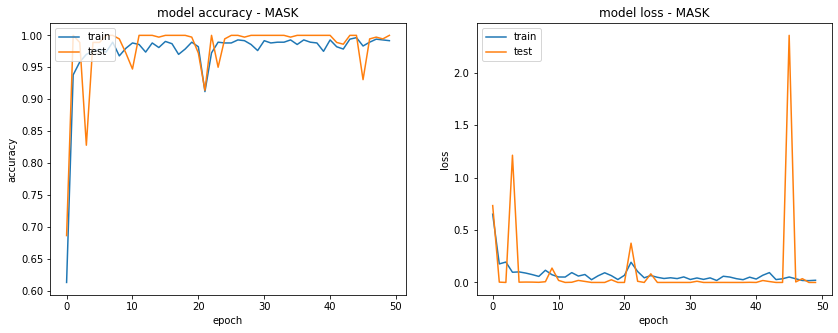

In [ ]:
plot_history(history_mask, 'mask')